<a href="https://colab.research.google.com/github/Sumayyah-Mohammedy/AIModel/blob/main/AIprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import xgboost as xgb
import numpy as np
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle

# Set the seed for numpy
np.random.seed(123)

# Display all columns of Pandas' dataframes by default
pd.set_option('display.max_columns', None)

data_path = './drive/MyDrive/kddcup.data.corrected'

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df =  pd.read_csv(data_path, header=None, names=col_names, index_col=False)

# Display the first few rows of the dataset
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
pd.DataFrame(df['label'].value_counts())

,count
label,
smurf.,2807886
neptune.,1072017
normal.,972781
satan.,15892
ipsweep.,12481
portsweep.,10413
nmap.,2316
back.,2203
warezclient.,1020


In [ ]:
le = LabelEncoder()
le.fit(df.label)
print(le.classes_)

['back.' 'buffer_overflow.' 'ftp_write.' 'guess_passwd.' 'imap.'
 'ipsweep.' 'land.' 'loadmodule.' 'multihop.' 'neptune.' 'nmap.' 'normal.'
 'perl.' 'phf.' 'pod.' 'portsweep.' 'rootkit.' 'satan.' 'smurf.' 'spy.'
 'teardrop.' 'warezclient.' 'warezmaster.']


In [ ]:
import numpy as np
import pandas as pd

def reduce_anomalies(df, pct_anomalies=0.10):
    labels = df['label']
    is_anomaly = labels != 'normal.'
    anomaly_df = df[is_anomaly]
    normal_df = df[~is_anomaly]
    num_anomalies = int(len(normal_df) * pct_anomalies)
    if num_anomalies > len(anomaly_df):
        num_anomalies = len(anomaly_df)
    sampled_anomalies = anomaly_df.sample(n=num_anomalies, random_state=42)

    new_df = pd.concat([normal_df, sampled_anomalies]).sample(frac=1, random_state=42).reset_index(drop=True)
    return new_df



In [ ]:

df = reduce_anomalies(df)

In [ ]:
pd.DataFrame(df['label'].value_counts())

,count
label,
normal.,972781
smurf.,6903
neptune.,2705
portsweep.,41
ipsweep.,34
satan.,28
back.,7
nmap.,6
warezclient.,2


In [ ]:
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

# find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

# check that the categorical variables were created correctly
cat_data.head()

,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [ ]:
numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

# check that the numeric data has been captured accurately
numeric_data.head()

,dst_host_srv_count,dst_host_srv_rerror_rate,dst_bytes,num_outbound_cmds,num_shells,diff_srv_rate,num_access_files,num_file_creations,srv_count,dst_host_serror_rate,rerror_rate,dst_host_same_srv_rate,hot,same_srv_rate,dst_host_srv_diff_host_rate,count,srv_rerror_rate,srv_diff_host_rate,num_failed_logins,num_compromised,src_bytes,dst_host_count,root_shell,wrong_fragment,dst_host_same_src_port_rate,dst_host_srv_serror_rate,dst_host_diff_srv_rate,duration,num_root,su_attempted,urgent,srv_serror_rate,dst_host_rerror_rate,serror_rate
0,255,0.00,447,0,0,0.0,0,0,8,0.0,0.0,1.00,0,1.0,0.03,4,0.00,0.38,0,0,246,4,0,0,0.25,0.0,0.00,0,0,0,0,0.0,0.00,0.0
1,245,0.00,146,0,0,0.0,0,0,1,0.0,0.0,0.96,0,1.0,0.00,1,0.00,0.00,0,0,105,255,0,0,0.01,0.0,0.01,0,0,0,0,0.0,0.00,0.0
2,255,0.71,1247,0,0,0.0,0,0,13,0.0,0.0,1.00,0,1.0,0.05,13,0.00,0.00,0,0,273,74,0,0,0.01,0.0,0.00,0,0,0,0,0.0,0.19,0.0
3,82,1.00,0,0,0,0.0,0,0,2,0.0,1.0,1.00,0,1.0,0.06,1,1.00,1.00,0,0,0,2,0,0,0.50,0.0,0.00,0,0,0,0,0.0,1.00,0.0
4,255,0.01,3250,0,0,0.0,0,0,54,0.0,0.0,1.00,0,1.0,0.03,10,0.02,0.09,0,0,202,10,0,0,0.10,0.0,0.00,0,0,0,0,0.0,0.00,0.0


In [ ]:
# concat numeric and the encoded categorical variables
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

# here we do a quick sanity check that the data has been concatenated correctly by checking the dimension of the vectors
print(cat_data.shape)
print(numeric_data.shape)
print(numeric_cat_data.shape)

(982508, 80)
(982508, 34)
(982508, 114)


In [ ]:
labels = df['label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25,
                                                    random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(736881, 114)
(736881,)
(245627, 114)
(245627,)


In [ ]:
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
path = './drive/MyDrive/preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()

In [ ]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1
    my_labels[my_labels == normal_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(le, y_train)
binary_y_test = convert_label_to_binary(le, y_test)

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())

Number of anomalies in y_train:  7240
Number of anomalies in y_test:   2487


In [ ]:
params = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'n_gpus':            1,
    'objective':         'binary:logistic',
    'verbose':           True
}

In [ ]:
x_train.head()

,dst_host_srv_count,dst_host_srv_rerror_rate,dst_bytes,num_outbound_cmds,num_shells,diff_srv_rate,num_access_files,num_file_creations,srv_count,dst_host_serror_rate,rerror_rate,dst_host_same_srv_rate,hot,same_srv_rate,dst_host_srv_diff_host_rate,count,srv_rerror_rate,srv_diff_host_rate,num_failed_logins,num_compromised,src_bytes,dst_host_count,root_shell,wrong_fragment,dst_host_same_src_port_rate,dst_host_srv_serror_rate,dst_host_diff_srv_rate,duration,num_root,su_attempted,urgent,srv_serror_rate,dst_host_rerror_rate,serror_rate,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
36290,255,0.00,7723,0,0,0.0,0,0,16,0.0,0.0,1.00,0,1.0,0.05,16,0.0,0.00,0,0,293,16,0,0,0.06,0.0,0.00,0,0,0,0,0.0,0.0,0.0,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
480901,255,0.00,2973,0,0,0.0,0,0,4,0.0,0.0,1.00,0,1.0,0.00,4,0.0,0.00,0,0,296,255,0,0,0.00,0.0,0.00,0,0,0,0,0.0,0.0,0.0,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
821832,251,0.98,0,0,0,0.0,0,0,1,0.0,1.0,1.00,0,1.0,0.14,1,1.0,0.00,0,0,0,1,0,0,1.00,0.0,0.00,0,0,0,0,0.0,1.0,0.0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
36335,255,0.00,22431,0,0,0.0,0,0,8,0.0,0.0,1.00,0,1.0,0.05,8,0.0,0.00,0,0,330,26,0,0,0.04,0.0,0.00,0,0,0,0,0.0,0.0,0.0,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
970286,7,0.00,0,0,0,0.0,0,0,3,0.0,0.0,0.16,0,1.0

In [ ]:
y_train[0:100]


array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 18,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 18, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 18, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [ ]:
%%time

dtrain = xgb.DMatrix(x_train, label=binary_y_train)
dtest = xgb.DMatrix(x_test, label=binary_y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

CPU times: user 4.42 s, sys: 681 ms, total: 5.1 s
Wall time: 3.1 s


In [ ]:
num_rounds = params['num_rounds']


In [ ]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:48:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_gpus", "num_rounds", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	test-logloss:0.13579	train-logloss:0.13539
[1]	test-logloss:0.12053	train-logloss:0.12022
[2]	test-logloss:0.10759	train-logloss:0.10734
[3]	test-logloss:0.09633	train-logloss:0.09611
[4]	test-logloss:0.08642	train-logloss:0.08623
[5]	test-logloss:0.07763	train-logloss:0.07748
[6]	test-logloss:0.06982	train-logloss:0.06969
[7]	test-logloss:0.06285	train-logloss:0.06273
[8]	test-logloss:0.05661	train-logloss:0.05652
[9]	test-logloss:0.05103	train-logloss:0.05095


In [ ]:
!nvidia-smi

Sat Oct 18 17:48:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             26W /   70W |     428MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
threshold = .5
true_labels = binary_y_test.astype(int)
true_labels.sum()

np.int64(2487)

In [ ]:
preds = model.predict(dtest)
print(preds)

[0.04677626 0.04677626 0.70950913 ... 0.04677626 0.04677626 0.04677626]


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [17:48:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


In [ ]:
pred_labels = (preds > threshold).astype(int)
print(pred_labels)

[0 0 1 ... 0 0 0]


In [ ]:
pred_labels.sum()

np.int64(2475)

In [ ]:
# compute the auc
auc = roc_auc_score(true_labels, preds)
print(auc)

0.999390404174257


In [ ]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))


Accuracy: 0.9999430030086269


Confusion Matrix :


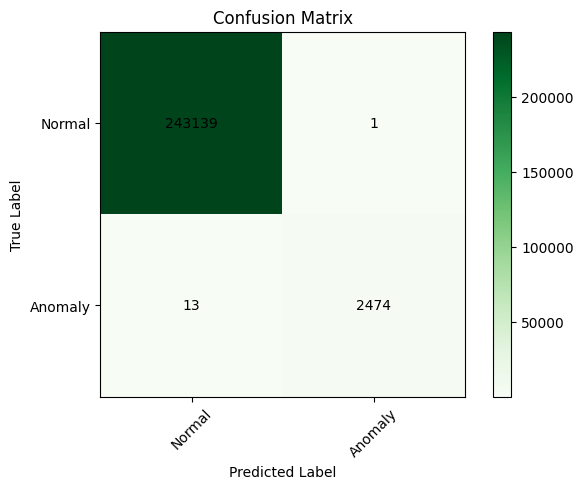

In [ ]:
results = confusion_matrix(true_labels, pred_labels)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

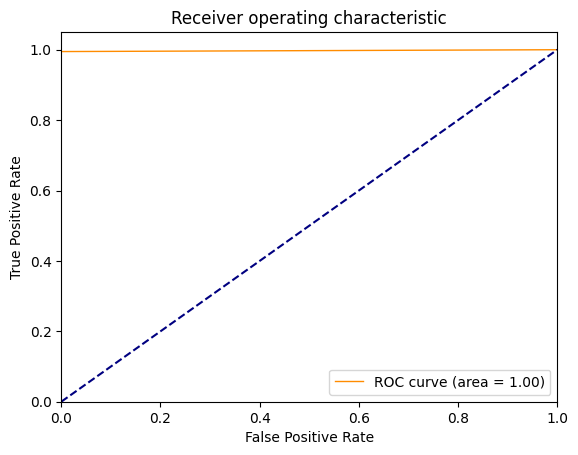

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
num_labels = len(le.classes_)
params['objective'] = 'multi:softprob'
params['num_class'] = num_labels
print(params)


{'num_rounds': 10, 'max_depth': 8, 'max_leaves': 256, 'alpha': 0.9, 'eta': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'subsample': 1, 'reg_lambda': 1, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist', 'n_gpus': 1, 'objective': 'multi:softprob', 'verbose': True, 'num_class': 23}


In [ ]:
%%time

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]
model = xgb.train(params, dtrain, num_rounds, evals=evals)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:50:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:50:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_gpus", "num_rounds", "scale_pos_weight", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	test-mlogloss:2.03011	train-mlogloss:2.03008
[1]	test-mlogloss:1.66621	train-mlogloss:1.66616
[2]	test-mlogloss:1.41781	train-mlogloss:1.41776
[3]	test-mlogloss:1.22865	train-mlogloss:1.22859
[4]	test-mlogloss:1.07663	train-mlogloss:1.07657
[5]	test-mlogloss:0.95049	train-mlogloss:0.95043
[6]	test-mlogloss:0.84358	train-mlogloss:0.84351
[7]	test-mlogloss:0.75162	train-mlogloss:0.75155
[8]	test-mlogloss:0.67167	train-mlogloss:0.67160
[9]	test-mlogloss:0.60161	train-mlogloss:0.60154
CPU times: user 6.89 s, sys: 546 ms, total: 7.43 s
Wall time: 5.39 s


In [ ]:
preds = model.predict(dtest)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [17:50:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


In [ ]:

pred_labels = np.argmax(preds, axis=1)

In [ ]:

pred_labels

array([11, 11, 18, ..., 11, 11, 11])

In [ ]:
true_labels = y_test

In [ ]:

true_labels

array([11, 11, 18, ..., 11, 11, 11])

In [ ]:
print ('Accuracy Score :', accuracy_score(true_labels, pred_labels))

Accuracy Score : 0.9998493650942283


Confusion Matrix :


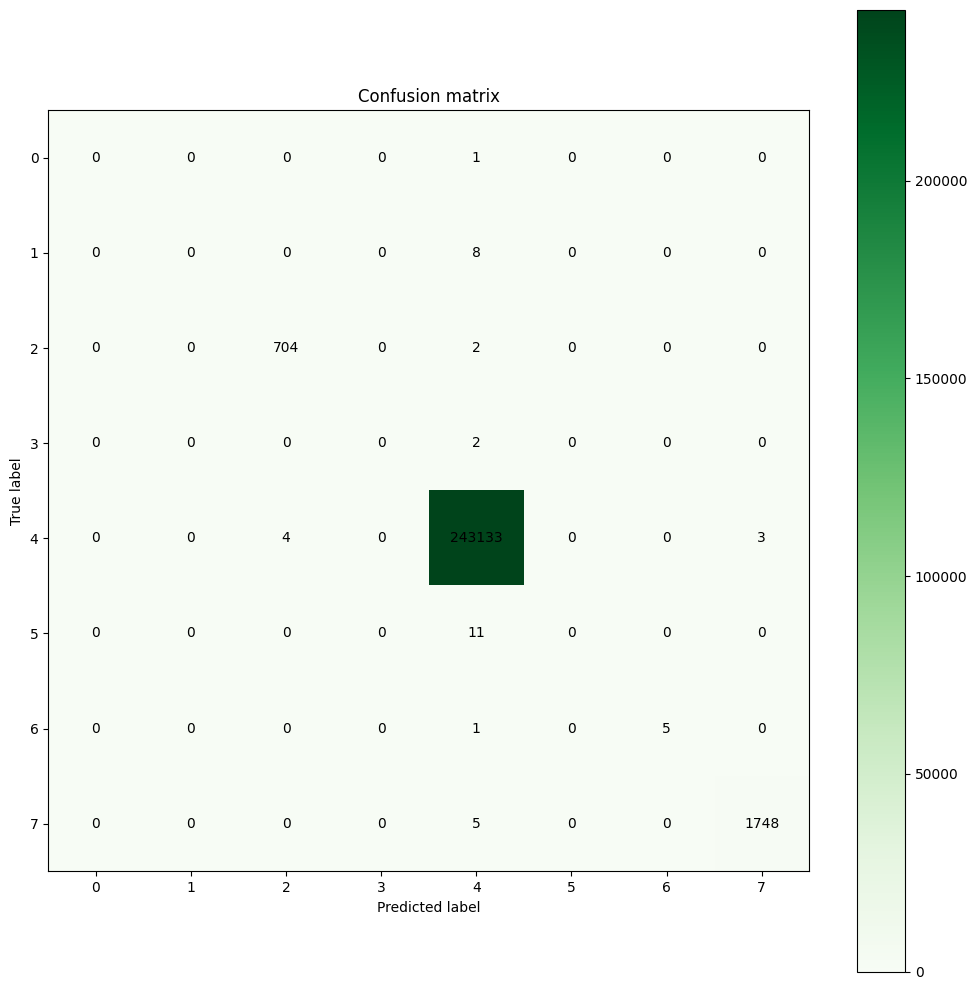

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    #tick_marks = np.arange(len(target_names))
    #plt.xticks(tick_marks, target_names, rotation=45)
    #plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

# Ensure labels are 1D
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# The model is multiclass, so use the predicted labels from argmax
y_pred = np.argmax(preds, axis=1)

# Compute metrics for multiclass classification
accuracy = accuracy_score(y_test_labels, y_pred)
# For precision, recall, and f1-score in multiclass, you need to specify an average method
# 'weighted' accounts for class imbalance
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# ROC AUC is typically for binary classification. For multiclass, you can use one-vs-rest or one-vs-one.
# If you need ROC AUC, you'd need to handle it differently for multiclass.
# Since the error is in the classification metrics, I will focus on fixing those first.

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# You can also print a classification report for more detailed metrics per class
print("\nClassification Report:")
# Get the unique labels present in the test set
unique_labels = np.unique(y_test_labels)
# Get the corresponding target names
target_names_subset = [le.classes_[i] for i in unique_labels]
print(classification_report(y_test_labels, y_pred, target_names=target_names_subset, labels=unique_labels))

Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9998

Classification Report:
              precision    recall  f1-score   support

       back.       0.00      0.00      0.00         1
    ipsweep.       0.00      0.00      0.00         8
    neptune.       0.99      1.00      1.00       706
       nmap.       0.00      0.00      0.00         2
     normal.       1.00      1.00      1.00    243140
  portsweep.       0.00      0.00      0.00        11
      satan.       1.00      0.83      0.91         6
      smurf.       1.00      1.00      1.00      1753

    accuracy                           1.00    245627
   macro avg       0.50      0.48      0.49    245627
weighted avg       1.00      1.00      1.00    245627



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m